In [1]:
cd ../..

/lfs/rambo/0/adobles/relbench-user-study


/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Feature Ideas

- `week_of_year`
- `month_of_year`
- `day_of_month`
- `day_of_week`
- `department_no`
- `section_no`
- `perceived_colour_master_id`
- For each 1 week window in the previous 5 weeks:
    - `num_sales`
    - `sold_amount`
    - `avg_price`
    - `num_customers`
    - Averaged across buyers in that week:
        - `avg_buyer_age`
        - `avg_monthly_purchase_amount`
        - `avg_monthly_purchase_count`
        - `avg_weeks_since_last_purchase`

In [3]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('hm/hm.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

In [53]:
with open('hm/sales/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=0))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [4]:
utils.validate_feature_tables('sales', conn)

Validating train
train labels size: 5,488,184 x 3
train feats size: 5,488,184 x 49

Validating val
val labels size: 105,542 x 3
val feats size: 105,542 x 49

Validating test
test labels size: 105,542 x 2
test feats size: 105,542 x 48

✅ All tables are valid!


In [5]:
%%sql train_df <<
from sales_train_feats

In [6]:
infer_df_stype(train_df)

{'article_id': <stype.categorical: 'categorical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'sales': <stype.numerical: 'numerical'>,
 'week_of_year': <stype.categorical: 'categorical'>,
 'month_of_year': <stype.categorical: 'categorical'>,
 'day_of_month': <stype.categorical: 'categorical'>,
 'department_no': <stype.categorical: 'categorical'>,
 'section_no': <stype.categorical: 'categorical'>,
 'perceived_colour_master_id': <stype.categorical: 'categorical'>,
 'num_sales_1_weeks_ago': <stype.numerical: 'numerical'>,
 'sold_amount_1_weeks_ago': <stype.numerical: 'numerical'>,
 'avg_price_1_weeks_ago': <stype.numerical: 'numerical'>,
 'num_customers_1_weeks_ago': <stype.numerical: 'numerical'>,
 'avg_buyer_age_1_weeks_ago': <stype.numerical: 'numerical'>,
 'avg_monthly_purchase_amount_1_weeks_ago': <stype.numerical: 'numerical'>,
 'avg_monthly_purchase_count_1_weeks_ago': <stype.numerical: 'numerical'>,
 'avg_weeks_since_last_purchase_1_weeks_ago': <stype.numerical: 'numerical'>,


In [7]:
utils.feature_summary_df(train_df.sample(20_000), 'sales', classification=False)

,Label Corr.,Label MI,NaN %
sold_amount_1_weeks_ago,0.761,0.371,81.2%
sold_amount_2_weeks_ago,0.728,0.341,81.1%
num_sales_1_weeks_ago,0.673,0.325,81.2%
avg_price_1_weeks_ago,0.187,0.321,81.2%
num_customers_1_weeks_ago,0.680,0.318,81.2%
sold_amount_3_weeks_ago,0.637,0.291,81.3%
num_customers_2_weeks_ago,0.591,0.279,81.1%
avg_price_2_weeks_ago,0.177,0.277,81.1%
num_sales_2_weeks_ago,0.589,0.277,81.1%
num_sales_3_weeks_ago,0.523,0.273,81.3%


## Feature Importances

In [8]:
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-hm-sales'

task_params = TASK_PARAMS[TASK]

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
%%sql val_df <<
select * from sales_val_feats;

In [12]:
val_tf = Dataset(
    val_df,
    col_to_stype=task_to_stypes[TASK],
    target_col=task_params['target_col'],
).materialize().tensor_frame

In [14]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

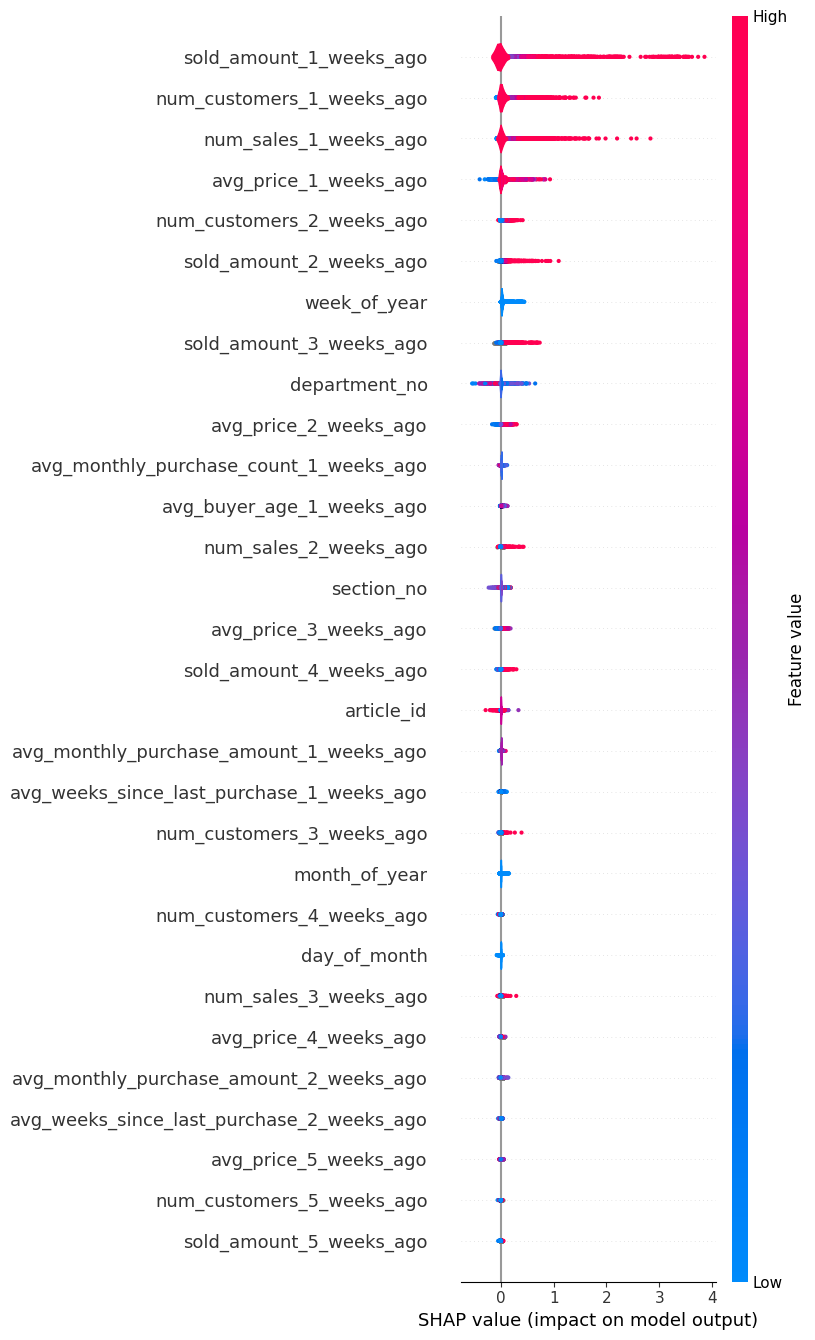

In [15]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[:10_000])
shap_values = explainer.shap_values(val_arr, pred[:10_000])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

In [16]:
conn.close()